In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import re
import nltk
nltk.download('punkt')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.corpus import brown
nltk.download('stopwords')
nltk.download('words')
words = set(nltk.corpus.words.words())
nltk.download('averaged_perceptron_tagger')
from nltk.stem import *
from nltk.stem.snowball import SnowballStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV

[nltk_data] Downloading package punkt to /Users/ali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/ali/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ali/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/ali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ali/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# MBTI data

In [3]:
data = pd.read_csv('mbti_1.csv')

In [4]:
pd.set_option('display.max_colwidth', 75)
data.shape

(8675, 2)

In [5]:
# Def function for removing ||| delimiters
def remove_delimiters(delimiters, s):
    new_s = s
    for i in delimiters:
        new_s = new_s.replace(i, ' ')
    return ' '.join(new_s.split())

# Expressions to drop
regex_todrop = ['[.+]','[(+]','[+)]','[+/+]','[:+:]','[+?]','[+/+]','[+~]','[+,+]',
                "[+'+]",'[+-+]','[_]']

# Joining all text data for cleaning
all_posts = ' '.join(data.posts)

# Dropping URLs, delimiters, numbers, stopwords
all_posts_cln = re.sub(r"\S*https?:\S*", "", all_posts)
all_posts_cln = re.sub(r'http\S+', "", all_posts_cln)
all_posts_cln = remove_delimiters('|||', all_posts_cln)
all_posts_cln = ''.join([i for i in all_posts_cln if not i.isdigit()])

In [6]:
# Dropping regex
all_text_cln = all_posts_cln

for r in regex_todrop:
    all_text_cln = re.sub(r, "", all_text_cln)

# Correcting case
all_text_cln = all_text_cln.lower()

# Quick check
all_text_cln[2000:2500]

'thing about peer pressure banned for a whole host of two baby deer on left and right munching on a beetle in the middle  using their own blood two cavemen diary todays latest happenings on their designated cave diary wall  i see it as a pokemon world an infj society everyone becomes an all artists are artists because they draw its the idea that counts in forming something of your own like a signature welcome to the robot ranks person who downed my self-esteem cuz im not an avid signature artist '

# Modeling

In [7]:
emo = pd.DataFrame(pd.read_csv('emotions.csv'))
emo_map = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
emo['emotion'] = emo['label'].map(emo_map)
emo.head()

,text,label,emotion
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being ...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is ...,2,love
4,i am feeling grouchy,3,anger


In [8]:
emo.emotion.value_counts()

emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [9]:
# Using the Brown corpus since nltk.corpus.words was missing a lot of plurals/progressives
nltk.download('brown')

wordlist = set(brown.words())
words = set(i.lower() for i in brown.words())

# Setting stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package brown to /Users/ali/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [10]:
# Tokenize, tag
emo['tkns'] = ''
emo['tags'] = ''

for i in range(len(emo.text)):
    emo['tkns'][i] = emo['text'][i].split()
    
for i in range(len(emo.tkns)):
    emo['tkns'][i] = [w for w in emo['tkns'][i] if w in words and w not in stop_words]
    
for i in range(len(emo.tkns)):
    tags = nltk.pos_tag(emo['tkns'][i])
    emo['tags'][i] = [w_pos[1] for w_pos in tags]

In [11]:
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

In [12]:
# Lemmatize
wn = nltk.WordNetLemmatizer()

emo['lems'] = np.empty((len(emo), 0)).tolist()

for i in range(len(emo.tkns)):
    tkns = emo.tkns[i]
    tags = emo.tags[i]
    for j in range(0, len(emo.tkns[i])):
        tkn = tkns[j]
        tag = get_wordnet_pos(tags[j])
        emo['lems'][i].append(wn.lemmatize(tkn, tag)\
                              if tag in ['j','v','n','r'] else tkn)
emo.head()

,text,label,emotion,tkns,tags,lems
0,i didnt feel humiliated,0,sadness,"[feel, humiliated]","[NN, VBD]","[feel, humiliate]"
1,i can go from feeling so hopeless to so damned hopeful just from being ...,0,sadness,"[go, feeling, hopeless, damned, hopeful, around, someone, cares, awake]","[VB, NN, NN, VBD, JJ, IN, NN, NNS, VBP]","[go, feeling, hopeless, damn, hopeful, around, someone, care, awake]"
2,im grabbing a minute to post i feel greedy wrong,3,anger,"[grabbing, minute, post, feel, greedy, wrong]","[VBG, NN, NN, NN, NN, JJ]","[grab, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplace i will know that it is ...,2,love,"[ever, feeling, nostalgic, fireplace, know, still, property]","[RB, VBG, JJ, NN, VBP, RB, NN]","[ever, feel, nostalgic, fireplace, know, still, property]"
4,i am feeling grouchy,3,anger,[feeling],[VBG],[feel]


In [13]:
emo['lem_txt'] = ''

for i in range(len(emo.lems)):
    lem_ls = emo.lems[i]
    lem_txt = ''
    for lem in lem_ls:
        lem_txt = ' '.join([lem_txt, lem])
    emo['lem_txt'][i] = lem_txt

for i in range(len(emo.lems)):
    lem_ls = emo.lems[i]
    lem_txt = ''
    for lem in lem_ls:
        lem_txt = ' '.join([lem_txt, lem])
    emo['lem_txt'][i] = lem_txt
        
emo.head()

,text,label,emotion,tkns,tags,lems,lem_txt
0,i didnt feel humiliated,0,sadness,"[feel, humiliated]","[NN, VBD]","[feel, humiliate]",feel humiliate
1,i can go from feeling so hopeless to so damned hopeful just from being ...,0,sadness,"[go, feeling, hopeless, damned, hopeful, around, someone, cares, awake]","[VB, NN, NN, VBD, JJ, IN, NN, NNS, VBP]","[go, feeling, hopeless, damn, hopeful, around, someone, care, awake]",go feeling hopeless damn hopeful around someone care awake
2,im grabbing a minute to post i feel greedy wrong,3,anger,"[grabbing, minute, post, feel, greedy, wrong]","[VBG, NN, NN, NN, NN, JJ]","[grab, minute, post, feel, greedy, wrong]",grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplace i will know that it is ...,2,love,"[ever, feeling, nostalgic, fireplace, know, still, property]","[RB, VBG, JJ, NN, VBP, RB, NN]","[ever, feel, nostalgic, fireplace, know, still, property]",ever feel nostalgic fireplace know still property
4,i am feeling grouchy,3,anger,[feeling],[VBG],[feel],feel


In [14]:
# Joining all lemmas for tfidf
emo_lems = ''

for i in range(0,len(emo.lems)):
    lem_ls = emo.lems[i]
    for lem in lem_ls:
        emo_lems = ' '.join([emo_lems, lem])

print(emo_lems[:100])

 feel humiliate go feeling hopeless damn hopeful around someone care awake grab minute post feel gre


In [15]:
tfidf = TfidfVectorizer(max_features = 100)
tfidf_emo = tfidf.fit_transform(emo.lem_txt)

tfidf_emo = pd.DataFrame(tfidf_emo.toarray(), columns = tfidf.get_feature_names_out())
tfidf_emo['label'] = emo.emotion

tfidf_emo.head()

,able,actually,alone,also,always,anything,around,away,back,bit,...,way,week,well,without,work,world,would,write,year,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sadness
1,0.0,0.0,0.0,0.0,0.0,0.0,0.479852,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sadness
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,anger
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,love
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,anger


In [16]:
X_emo = tfidf_emo.drop('label', axis = 1)
y_emo = tfidf_emo.label

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_emo, y_emo, random_state = 17,
                                                    train_size = .75)

In [18]:
emo_lr = LogisticRegression(n_jobs = -1, max_iter = 1000, random_state = 17)
emo_lr.fit(X_train, y_train)

y_pred = emo_lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.365

In [19]:
solvers = ['newton-cg','lbfgs','liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

param_grid = dict(solver = solvers, penalty = penalty, C = c_values)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 17)

lr_gs = GridSearchCV(estimator = emo_lr,
                           param_grid = param_grid,
                           n_jobs = -1,
                           cv = cv,
                           scoring = 'accuracy')

lr_gs_res = lr_gs.fit(X_train, y_train)

print("Best: %f using %s" % (lr_gs_res.best_score_, lr_gs_res.best_params_))

/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 's

/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 's

/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 's

/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Best: 0.364861 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


Best: 0.364861 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}

In [20]:
emo_lr = LogisticRegression(C = 0.1, penalty = 'l2', solver = 'newton-cg', random_state = 17)
emo_lr.fit(X_train, y_train)

y_pred = emo_lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.36475

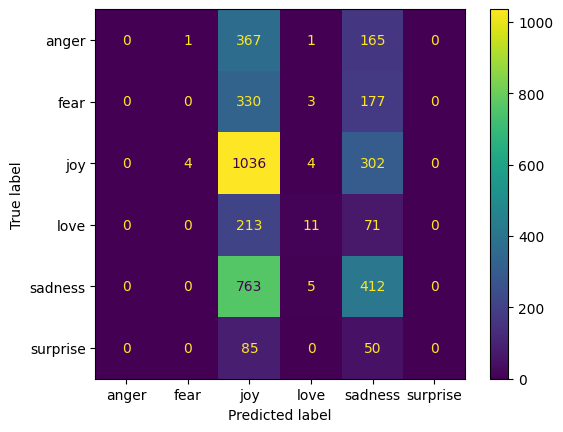

In [21]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(cnf_matrix, display_labels = emo_lr.classes_)

disp.plot()
plt.show();

Poor on joy, sadness
Okay on fear, love
Did not predict any anger, surprise?

In [22]:
y_test.value_counts()

label
joy         1346
sadness     1180
anger        534
fear         510
love         295
surprise     135
Name: count, dtype: int64

In [23]:
Counter(y_pred)

Counter({'joy': 2794, 'sadness': 1177, 'love': 24, 'fear': 5})

In [24]:
emo_rf = RandomForestClassifier(n_jobs = -1, random_state = 17)
emo_rf.fit(X_train, y_train)

rf_pred = emo_rf.predict(X_test)
accuracy_score(rf_pred, y_test)

0.348

In [25]:
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 2000, num = 20)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_gs = RandomizedSearchCV(estimator = emo_rf, param_distributions = param_grid,
                           n_iter = 50, cv = 3, verbose = 1, random_state = 17,
                           n_jobs = -1)

rf_gs_res = rf_gs.fit(X_train, y_train)

print("Best: %f using %s" % (rf_gs_res.best_score_, rf_gs_res.best_params_))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best: 0.361667 using {'n_estimators': 736, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': True}


Best: 0.361667 using {'n_estimators': 736, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': True}

In [26]:
emo_rf = RandomForestClassifier(n_estimators = 736, min_samples_split = 10,
                                min_samples_leaf = 4, max_depth = 30, bootstrap = True,
                                random_state = 17)
emo_rf.fit(X_train, y_train)
y_pred = emo_rf.predict(X_test)

accuracy_score(y_test, y_pred)

0.362

# Predicting on MBTI data

In [27]:
def clean_post(post):
    clean = re.sub(r"\S*https?:\S*", "", post)
    clean = re.sub(r'http\S+', "", clean)
    clean = remove_delimiters('|||', clean)
    clean = ''.join([i for i in clean if not i.isdigit()])
    for r in regex_todrop:
        clean = re.sub(r, "", clean).lower()
    return clean

def tokenize(string):
    tkns = string.split()
    return tkns

In [28]:
data['tkns'] = ''
data['tags'] = ''

for i in range(len(data.posts)):
    clean = tokenize(clean_post(data.posts[i]))
    data['tkns'][i] = clean

for i in range(len(data.tkns)):
    tags = nltk.pos_tag(data.tkns[i])
    data['tags'][i] = [w_pos[1] for w_pos in tags]

In [29]:
data['lems'] = data.apply(lambda x: [], axis=1)

for i in range(len(data.tkns)):
    tkns = data.tkns[i]
    tags = data.tags[i]
    for j in range(0,len(data.tkns[i])):
        tkn = tkns[j]
        tag = get_wordnet_pos(tags[j])
        data['lems'][i].append(wn.lemmatize(tkn, tag) if tag in ['j','v','n','r'] else tkn)

In [30]:
data['lem_txt'] = ''

for i in range(len(data.lems)):
    lem_ls = data.lems[i]
    lem_txt = ''
    for lem in lem_ls:
        lem_txt = ' '.join([lem_txt, lem])
    data['lem_txt'][i] = lem_txt

In [31]:
data.to_csv('processed_data.csv', sep = ',')

In [32]:
tfidf_d = tfidf.fit_transform(data.lem_txt)

tfidf_d = pd.DataFrame(tfidf_d.toarray(), columns = tfidf.get_feature_names_out())
tfidf_d['label'] = data.type

tfidf_d.head()

,about,all,also,always,an,and,at,be,because,but,...,when,who,will,with,work,would,you,your,youre,label
0,0.022628,0.091254,0.000000,0.027837,0.067843,0.264456,0.068314,0.374517,0.073364,0.000000,...,0.045880,0.025357,0.027192,0.088651,0.000000,0.023809,0.132503,0.184626,0.031418,INFJ
1,0.020793,0.031446,0.037442,0.025580,0.093516,0.334151,0.031388,0.394769,0.033708,0.040718,...,0.063242,0.000000,0.087456,0.122198,0.039225,0.043758,0.223230,0.053019,0.057743,ENTP
2,0.058417,0.014724,0.000000,0.053899,0.072980,0.256030,0.044092,0.455007,0.047351,0.071498,...,0.059225,0.016366,0.052651,0.057218,0.073467,0.030734,0.185295,0.104267,0.060834,INTP
3,0.062748,0.063264,0.050216,0.000000,0.031356,0.162968,0.010525,0.539645,0.045209,0.071678,...,0.021205,0.000000,0.000000,0.102432,0.013152,0.044017,0.173513,0.063998,0.087125,INTJ
4,0.031435,0.042258,0.012579,0.012891,0.031417,0.214315,0.021090,0.683529,0.045298,0.061558,...,0.042493,0.105683,0.012592,0.092369,0.013178,0.055128,0.163626,0.021374,0.014549,ENTJ


In [33]:
tfidf_emo.head()

,able,actually,alone,also,always,anything,around,away,back,bit,...,way,week,well,without,work,world,would,write,year,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sadness
1,0.0,0.0,0.0,0.0,0.0,0.0,0.479852,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sadness
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,anger
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,love
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,anger


In [34]:
emo_data_words = [col for col in tfidf_emo.columns if col in tfidf_d.columns]
tf_idf = tfidf_d[emo_data_words]
tf_idf.head()

,also,always,come,even,feel,find,friend,get,go,good,...,think,time,try,use,want,way,well,work,would,label
0,0.000000,0.027837,0.027045,0.027016,0.000000,0.000000,0.028156,0.022664,0.000000,0.076901,...,0.045005,0.140045,0.052314,0.055634,0.024803,0.025310,0.000000,0.000000,0.023809,INFJ
1,0.037442,0.025580,0.024852,0.012413,0.000000,0.023766,0.051748,0.041654,0.053709,0.011778,...,0.031018,0.042897,0.024037,0.063905,0.045585,0.034888,0.011320,0.039225,0.043758,ENTP
2,0.000000,0.053899,0.000000,0.034874,0.016336,0.033384,0.036346,0.029256,0.045267,0.115812,...,0.072619,0.015065,0.016882,0.017954,0.016009,0.016336,0.031802,0.073467,0.030734,INTP
3,0.050216,0.000000,0.024999,0.037459,0.000000,0.011953,0.000000,0.041899,0.021610,0.000000,...,0.052001,0.021575,0.000000,0.000000,0.034390,0.023396,0.011387,0.013152,0.044017,INTJ
4,0.012579,0.012891,0.012524,0.025021,0.000000,0.000000,0.000000,0.041982,0.075784,0.083094,...,0.093786,0.043235,0.036339,0.025763,0.057430,0.011721,0.011409,0.013178,0.055128,ENTJ


In [35]:
data_words = [col for col in tfidf_d.columns if col in tfidf_emo.columns]
tf_idf2 = tfidf_emo[data_words]
tf_idf2.head()

,also,always,come,even,feel,find,friend,get,go,good,...,think,time,try,use,want,way,well,work,would,label
0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sadness
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.364919,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sadness
2,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,anger
3,0.0,0.0,0.0,0.0,0.140387,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,love
4,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,anger


In [36]:
X = tf_idf.drop('label', axis = 1)

model = LogisticRegression(C = 0.1, penalty = 'l2', solver = 'newton-cg', random_state = 17)
model.fit(tf_idf2.drop('label', axis = 1), tf_idf2.label)

emo_pred = model.predict_proba(X)
emo_pred.shape # 8675 posts, 6 emotions

(8675, 6)

In [37]:
model.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [90]:
emotion_columns = ['anger_e','fear_e','joy_e','love_e','sadness_e','surprise_e']
emo_pred_df = pd.DataFrame(emo_pred, columns = emotion_columns)

In [91]:
tfidf_mbti_w_emo = pd.concat([tfidf_d, emo_pred_df], axis = 1)
tfidf_mbti_w_emo.head()

,about,all,also,always,an,and,at,be,because,but,...,you,your,youre,label,anger_e,fear_e,joy_e,love_e,sadness_e,surprise_e
0,0.022628,0.091254,0.000000,0.027837,0.067843,0.264456,0.068314,0.374517,0.073364,0.000000,...,0.132503,0.184626,0.031418,INFJ,0.135764,0.117830,0.323762,0.081149,0.303030,0.038466
1,0.020793,0.031446,0.037442,0.025580,0.093516,0.334151,0.031388,0.394769,0.033708,0.040718,...,0.223230,0.053019,0.057743,ENTP,0.138154,0.115532,0.322613,0.088840,0.297431,0.037430
2,0.058417,0.014724,0.000000,0.053899,0.072980,0.256030,0.044092,0.455007,0.047351,0.071498,...,0.185295,0.104267,0.060834,INTP,0.129505,0.116293,0.352338,0.078601,0.282931,0.040332
3,0.062748,0.063264,0.050216,0.000000,0.031356,0.162968,0.010525,0.539645,0.045209,0.071678,...,0.173513,0.063998,0.087125,INTJ,0.145261,0.123895,0.317924,0.076562,0.293479,0.042879
4,0.031435,0.042258,0.012579,0.012891,0.031417,0.214315,0.021090,0.683529,0.045298,0.061558,...,0.163626,0.021374,0.014549,ENTJ,0.141940,0.126254,0.327624,0.075333,0.290540,0.038309


In [92]:
tfidf_mbti_w_emo.to_csv('tfidf_w_sentiment.csv', sep = ',')

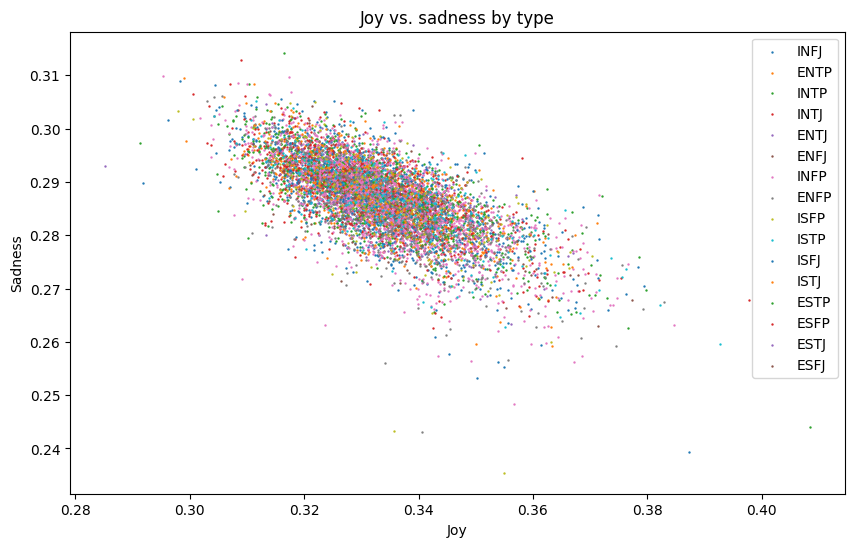

In [41]:
import seaborn as sns

plt.figure(figsize = (10,6))

for c in tfidf_mbti_w_emo['label'].unique():
    subset = tfidf_mbti_w_emo[tfidf_mbti_w_emo['label'] == c]
#    plt.scatter(subset['anger'], subset['fear'], subset['joy'], subset['love'], subset['sadness'],
#                subset['surprise'], label = c)
    plt.scatter(subset['joy'], subset['sadness'], label = c, s = .5)
    
plt.xlabel('Joy')
plt.ylabel('Sadness')
plt.title('Joy vs. sadness by type')
plt.legend()
plt.show()

In [94]:
df = tfidf_mbti_w_emo[['label','anger_e','fear_e','joy_e','love_e','sadness_e','surprise_e']].copy()

In [95]:
df.head()

,label,anger_e,fear_e,joy_e,love_e,sadness_e,surprise_e
0,INFJ,0.135764,0.117830,0.323762,0.081149,0.303030,0.038466
1,ENTP,0.138154,0.115532,0.322613,0.088840,0.297431,0.037430
2,INTP,0.129505,0.116293,0.352338,0.078601,0.282931,0.040332
3,INTJ,0.145261,0.123895,0.317924,0.076562,0.293479,0.042879
4,ENTJ,0.141940,0.126254,0.327624,0.075333,0.290540,0.038309


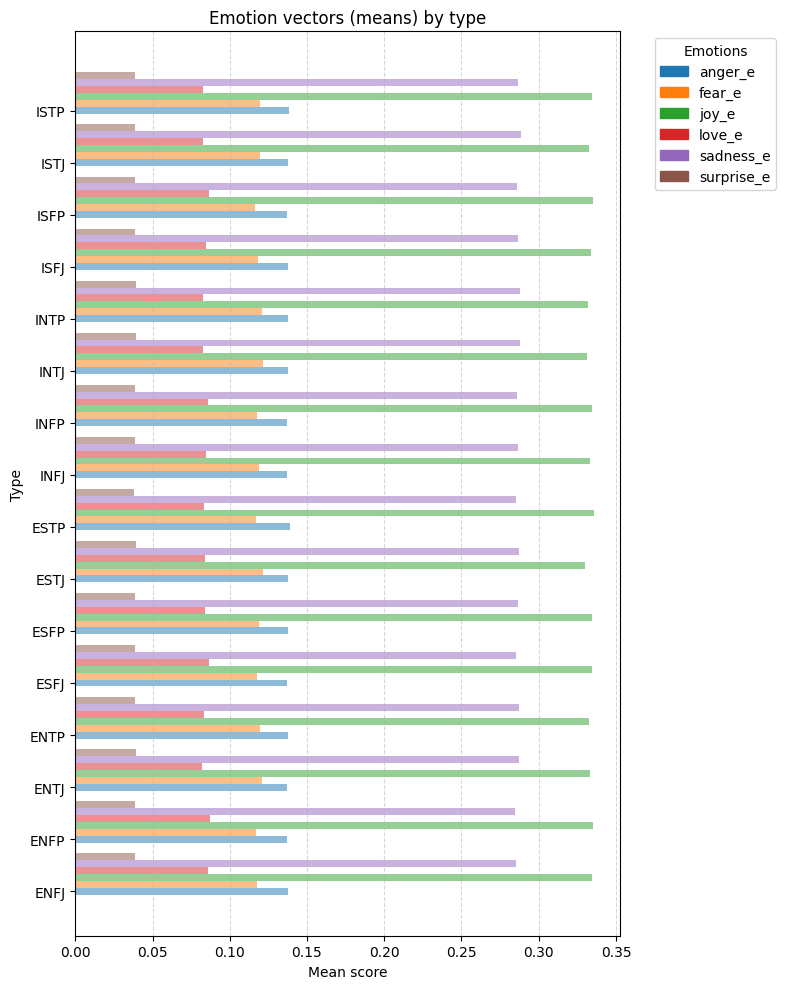

In [97]:
plt.figure(figsize = (8,10))

grouped_df = df.groupby('label')

# Calculate the number of emotions
num_emotions = len(df.columns[1:])

# Calculate the total width for each group of bars (including the space)
bar_width = 2
total_width = bar_width * num_emotions
space_width = 0.5  # Adjust as needed
group_width = total_width + (num_emotions - 1) * space_width

# Calculate the positions for each class
class_positions = np.arange(len(grouped_df)) * (group_width + space_width)

# Plot emotions for each class
for j, var in enumerate(df.columns[1:]):  # Exclude the 'label' column
    bar_positions = class_positions + j * bar_width
    
    # Plot emotion values for each class
    for i, (label, group) in enumerate(grouped_df):
        plt.barh(bar_positions[i], group[var].mean(), height=bar_width, color=f'C{j}', label=var, alpha=0.5)

# Customize the plot
plt.yticks(class_positions, grouped_df.groups.keys())  # Set y-ticks to class labels
plt.ylabel('Type')
plt.xlabel('Mean score')
plt.title('Emotion vectors (means) by type')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add legend entries outside the loop
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=f'C{j}', edgecolor='none') for j in range(len(df.columns[1:]))]
plt.legend(legend_handles, df.columns[1:], title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

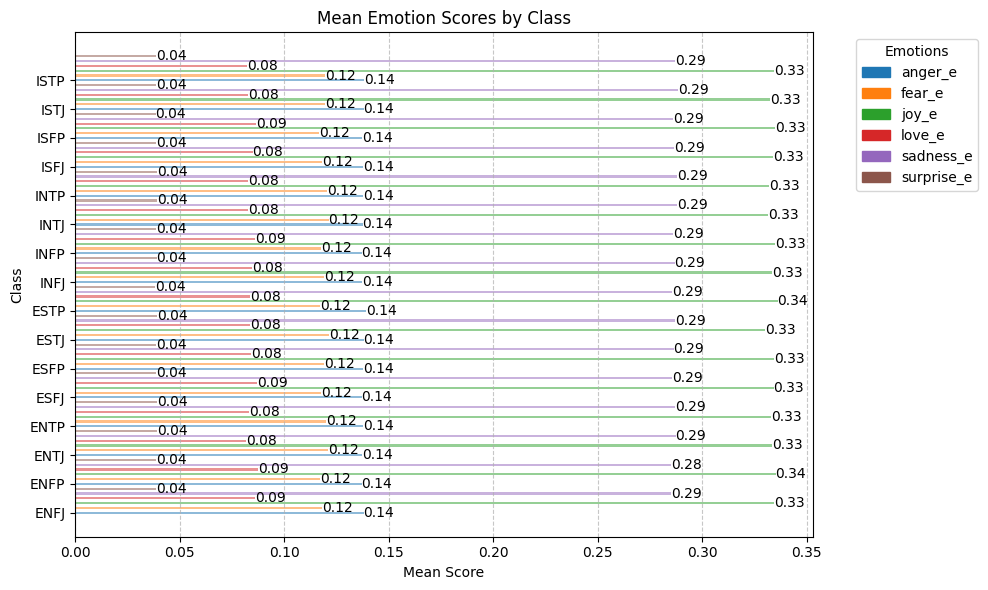

In [100]:
plt.figure(figsize=(10, 6))

# Define the bar width
bar_width = 0.4  # Adjust as needed

# Calculate the number of emotions
num_emotions = len(df.columns[1:])

# Calculate the total width for each group of bars (including the space)
total_width = bar_width * num_emotions
space_width = 0.5  # Adjust as needed
group_width = total_width + (num_emotions - 1) * space_width

# Calculate the positions for each class
class_positions = np.arange(len(grouped_df)) * (group_width + space_width)

# Plot emotions for each class
for j, var in enumerate(df.columns[1:]):  # Exclude the 'label' column
    bar_positions = class_positions + j * (bar_width + space_width)
    
    # Plot emotion values for each class
    for i, (label, group) in enumerate(grouped_df):
        mean_value = group[var].mean()
        plt.barh(bar_positions[i], mean_value, height=bar_width, color=f'C{j}', label=var, alpha=0.5)
        
        # Add value labels
        plt.text(mean_value, bar_positions[i], f'{mean_value:.2f}', ha='left', va='center')

# Customize the plot
plt.yticks(class_positions, grouped_df.groups.keys())  # Set y-ticks to class labels
plt.ylabel('Class')
plt.xlabel('Mean Score')
plt.title('Mean Emotion Scores by Class')
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines

# Add legend entries outside the loop
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=f'C{j}', edgecolor='none') for j in range(len(df.columns[1:]))]
plt.legend(legend_handles, df.columns[1:], title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()